The dataset for this BINARY CLASSIFIER to be used is [bc-dataset.csv].
There are 2 implementations here:
1. **Bag of words approach.**
2. Word vectors (can be pre-trained word embeddings).

The dataset split is 60-40.
Evaluation metrics to be used in this are:
1. Precision.
2. Recall.
3. F-Measure.

Loads the dataset.

In [1]:
from ftfy import fix_encoding
import pandas as pd
import random
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.utils import shuffle
import numpy as np
import re
import csv
import nltk as nlp
from nltk.corpus import stopwords

nlp.download("stopwords")
nlp.download('punkt')
nlp.download('wordnet')

def fix_encode(x):
    return fix_encoding(x)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

df = pd.read_csv(
    "datasets/bc-dataset.csv",
    encoding="latin1",
    sep=",",
    quoting=csv.QUOTE_ALL
)

data = pd.concat([df.gender, df['gender:confidence'], df.text], axis=1)

#drop null rows
print("Data Shape: " + str(data.shape))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Data Shape: (20050, 3)


Shows some descriptive stats (just for fun).
Also applies ftfy encoding to the ['text'] Column to fix any broken encodings when the .csv file was loaded.

In [2]:
print("Data Shape: " + str(data.shape))
print("Data Columns: " + str(data.columns))

# print("Just some stats.")
# print("------")
# print(data['gender'].describe())
# print("------")
# print(data['gender'].value_counts(ascending=True))

Data Shape: (20050, 3)
Data Columns: Index(['gender', 'gender:confidence', 'text'], dtype='object')


UNKNOWN and NAN values in *gender* column are discarded.

In [4]:
get_female = data["gender"] == "female"
get_male = data["gender"] == "male"
get_brand = data["gender"] == "brand"

female_rows = data[get_female]
male_rows = data[get_male]
brand_rows = data[get_brand]

print("total female tweets: ", female_rows.text.count())
print("total male tweets:   ", male_rows.text.count())
print("total brand tweets:  ", brand_rows.text.count())

total female tweets:  6700
total male tweets:    6194
total brand tweets:   5942


In [5]:
female_rows.gender = 0     # female
male_rows.gender = 1       # male
brand_rows.gender = 2      # brand) 

C:\Users\LENOVO\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
frames = [female_rows, male_rows, brand_rows]
data = pd.concat(frames, ignore_index=True)

In [7]:
# for testing purposes
# data.iloc[231]
data.columns

Index(['gender', 'gender:confidence', 'text'], dtype='object')

In [8]:
data.text = data.text.apply(lambda x: fix_encode(x))

print(str(data.shape))
data.dropna(subset=['text', 'gender'], inplace=True)
data = data.reset_index(drop=True)

# Data Shape: (20050, 26)
# Data Shape: (16306, 26)
print(str(data.shape))

(18836, 3)
(18836, 3)


In [9]:
import string 

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

data['text']=data['text'].apply(lambda x : remove_URL(x))
data['text']=data['text'].apply(lambda x : remove_html(x))
data['text']=data['text'].apply(lambda x : remove_emoji(x))
data['text']=data['text'].apply(lambda x : remove_punct(x))

In [13]:
print("ORIGINAL: ", data.text.iloc[8721])

ORIGINAL:  illamiina yes exactly as I wouldve done when elena was drowning I dont see the difference


In [20]:
data.drop(data[data['gender:confidence'] < 0.80].index, inplace=True)
data.drop('gender:confidence', axis=1, inplace=True)
# data.dropna(subset=['gender'], inplace=True)
print(str(data.shape))

(13817, 2)


In [15]:
lemma = nlp.WordNetLemmatizer()
description_list = []   # empty list
tweet_list = []   # empty list

# should pronouns be counted as stopwords?

for each in data.text:
    each = re.sub("[^a-zA-Z]"," ", str(each))                                        # regex to clean unnecesarry chars
    each = each.lower()                                                              # lowercase all
    each = nlp.word_tokenize(each)                                                   # split all by tokenizing
    each = [word for word in each if not word in set(stopwords.words("english"))]    # delete stop words from your array
    each = [lemma.lemmatize(word) for word in each]                                  # lemmatize "memories" -> "memory"
    each = " ".join(each)                                                            # make them one string again
    tweet_list.append(each)                                                         # put them into big array

print("ORIGINAL: ", data.text.iloc[123])
print("PREPROCESSED: ", tweet_list[123])

ORIGINAL:  Girl of the month  
PREPROCESSED:  girl month


In [21]:
print(str(data.shape))

(13817, 2)


In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# arbitrarily set it 
MAX_FEATURES = 4000
count_vectorizer = CountVectorizer(max_features=MAX_FEATURES, stop_words='english')
sparse_matrix = count_vectorizer.fit_transform(tweet_list).toarray()
words = count_vectorizer.get_feature_names()

In [23]:
# print(words[:100])

X = sparse_matrix
y = data.gender.values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [35]:
# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

y_pred_nb = nb_classifier.predict(X_test)

print(classification_report(y_test, y_pred_nb, digits=5))
print("Mean accuracy: ", nb_classifier.score(X_test, y_test))
print("WEIGHTED F-measure: ", f1_score(y_test, y_pred_nb, average="weighted"))
print("WEIGHTED Precision: ", precision_score(y_test, y_pred_nb, average="weighted"))
print("WEIGHTED Recall: ", recall_score(y_test, y_pred_nb, average="weighted"))

              precision    recall  f1-score   support

           0    0.53722   0.64486   0.58614      2171
           1    0.46228   0.40594   0.43228      1887
           2    0.62342   0.53642   0.57666      1469

    accuracy                        0.53447      5527
   macro avg    0.54097   0.52907   0.53169      5527
weighted avg    0.53455   0.53447   0.53109      5527

Mean accuracy:  0.5344671612086123
WEIGHTED F-measure:  0.5310898368047072
WEIGHTED Precision:  0.5345456549441825
WEIGHTED Recall:  0.5344671612086123


In [36]:
lr_classifier = LogisticRegression(max_iter=5000)
lr_classifier.fit(X_train, y_train)

y_pred_lr = lr_classifier.predict(X_test)

print(classification_report(y_test, y_pred_lr, digits=5))
print("Mean accuracy: ", lr_classifier.score(X_test, y_test))
print("WEIGHTED F-measure: ", f1_score(y_test, y_pred_lr, average="weighted"))
print("WEIGHTED Precision: ", precision_score(y_test, y_pred_lr, average="weighted"))
print("WEIGHTED Recall: ", recall_score(y_test, y_pred_lr, average="weighted"))

              precision    recall  f1-score   support

           0    0.52846   0.59880   0.56143      2171
           1    0.44501   0.41600   0.43002      1887
           2    0.59094   0.52417   0.55556      1469

    accuracy                        0.51656      5527
   macro avg    0.52147   0.51299   0.51567      5527
weighted avg    0.51657   0.51656   0.51500      5527

Mean accuracy:  0.5165550931789398
WEIGHTED F-measure:  0.5150045420458254
WEIGHTED Precision:  0.5165749081319531
WEIGHTED Recall:  0.5165550931789398


In [37]:
rfc_classifier = RandomForestClassifier(n_estimators = 100)
rfc_classifier.fit(X_train, y_train)

y_head_rfc = rfc_classifier.predict(X_test)

print(classification_report(y_test, y_head_rfc, digits=5))
print("Mean accuracy: ", rfc_classifier.score(X_test, y_test))
print("WEIGHTED F-measure: ", f1_score(y_test, y_head_rfc, average="weighted"))
print("WEIGHTED Precision: ", precision_score(y_test, y_head_rfc, average="weighted"))
print("WEIGHTED Recall: ", recall_score(y_test, y_head_rfc, average="weighted"))

              precision    recall  f1-score   support

           0    0.51171   0.59374   0.54968      2171
           1    0.42167   0.39799   0.40949      1887
           2    0.61043   0.50987   0.55564      1469

    accuracy                        0.50461      5527
   macro avg    0.51461   0.50053   0.50494      5527
weighted avg    0.50721   0.50461   0.50340      5527

Mean accuracy:  0.5046137144924914
WEIGHTED F-measure:  0.5033997976294795
WEIGHTED Precision:  0.5072094202377095
WEIGHTED Recall:  0.5046137144924914


# MODEL

RandomForestClassifier()

In [86]:
# mean accuracy
rfc.score(X_test, y_test)

0.5678853277500403

In [87]:
# y pred
y_head_ml = rfc.predict(X_test)

In [88]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_head_ml)

f_measure = f1_score(y_test, y_head_ml, average="weighted")
precision_measure = precision_score(y_test, y_head_ml, average="weighted")
recall_measure = recall_score(y_test, y_head_ml, average="weighted")


In [89]:
print(f_measure)
print(precision_measure)
print(recall_measure)

0.5650056724691268
0.5687736486936054
0.5678853277500403


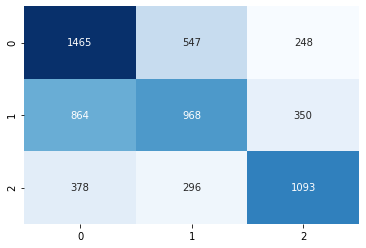

In [90]:
# for confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, cbar=False, annot=True, cmap="Blues", fmt="d")
plt.show()

In [91]:
# for quick and dirty counting
from collections import defaultdict

# the Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
# function to split the data for cross-validation
from sklearn.model_selection import train_test_split
# function for transforming documents into counts
from sklearn.feature_extraction.text import CountVectorizer
# function for encoding categories
from sklearn.preprocessing import LabelEncoder

nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

f_measure_nb = f1_score(y_test, y_pred_nb, average="weighted")
precision_measure_nb = precision_score(y_test, y_pred_nb, average="weighted")
recall_measure_nb = recall_score(y_test, y_pred_nb, average="weighted")

print("Mean accuracy: ", nb.score(X_test, y_test))
print("F-measure: ", f_measure_nb)
print("Precision: ", precision_measure_nb)
print("Recall: ", recall_measure_nb)


Mean accuracy:  0.5864068287969078
F-measure:  0.5829820294973996
Precision:  0.5928806822075628
Recall:  0.5864068287969078


In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Logistic Regression
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

f_measure_lr = f1_score(y_test, y_pred_lr, average="weighted")
precision_measure_lr = precision_score(y_test, y_pred_lr, average="weighted")
recall_measure_lr = recall_score(y_test, y_pred_lr, average="weighted")

print("Mean accuracy: ", nb.score(X_test, y_test))
print("F-measure: ", f_measure_lr)
print("Precision: ", precision_measure_lr)
print("Recall: ", recall_measure_lr)

Mean accuracy:  0.5864068287969078
F-measure:  0.5704928489224667
Precision:  0.5819557132712734
Recall:  0.5725559671444677
